In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import basinhopping
import multiprocessing as mp
import tqdm
import itertools

In [3]:
# Load spectrum data:
df = pd.read_excel('espectro.xlsx')
lambdas = df['Lambda (nm)'].values
film = df['Película'].values
glass = df['Vidrio'].values
cut = np.where(lambdas > 530)
lambdas = lambdas[cut]
film = film[cut]
glass = glass[cut]
s = 1/glass + np.sqrt(1/glass - 1)

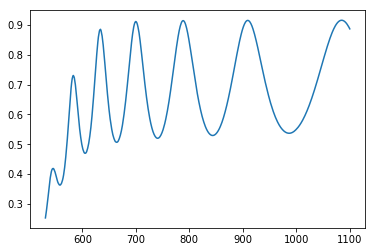

In [4]:
# Plot of thin film transmision:
plt.plot(lambdas, film)
plt.show()

In [5]:
# Swaneopel function for transmision:
def T_at_lambda(lam, n, s, d, alpha):
    """
    n and alpha are NOT functions of lam in this function.
    The function computes equaiton (4) of Swanepoel's paper.
    """
    A = 16*n*n*s
    B = (n+1)**3*(n+s*s)
    C = 2*(n*n-1)*(n*n-s*s)
    D = (n-1)**3*(n-s*s)
    phi = 4*np.pi*n*d/lam
    x = np.exp(-alpha*d)
    return A*x/(B-C*x*np.cos(phi)+ D*x*x)

In [7]:
# Function to get the best list of n and alpha corresponding to d:
def get_coefs(lambdas, s, d, experimental):
    def solve_coefs(x, s, d, lam, experimental):
        n = x[0]
        alpha = x[1]
        return abs(T_at_lambda(lam, n, s, d, alpha) - experimental)
    n_list = np.empty(len(lambdas))
    alpha_list = np.empty(len(lambdas))
    diff_list = np.empty(len(lambdas))
    x0 = [1.5, 1e-5]
    for index, lam in enumerate(lambdas):
        #simple minimization:
        #min_info = minimize(solve_coefs, x0=x0, args=(s, d, lam, experimental[index]), bounds=([1, 3], [0, 1e-1]), method='TNC')
        #global minimization:
        minimizer_kwargs = dict(args=(s[index], d, lam, experimental[index]), bounds=([1, 3], [0, 1e-1]), method='TNC')
        min_info = basinhopping(solve_coefs, x0=x0, minimizer_kwargs=minimizer_kwargs)
        n_sol, alpha_sol = min_info['x']
        x0 = [n_sol, alpha_sol] # new x0
        difference_fit = min_info['fun']
        #print(min_info['message'])
        n_list[index] = n_sol
        alpha_list[index] = alpha_sol
        diff_list[index] = difference_fit
    return n_list, alpha_list, diff_list

In [17]:
ds = np.linspace(50,150, 50)  # list of possible values for d

def worker_func(d):
    return get_coefs(lambdas, s, d, film)

In [18]:
with mp.Pool(4) as p:
    r = list(tqdm.tqdm(p.imap(worker_func, ds), total=ds.shape[0]))

100%|██████████| 50/50 [26:54<00:00, 32.29s/it]  


In [19]:
tot_dists = [np.sum(res[2])+np.var(np.diff(res[0]))+np.var(np.diff(res[1])) for res in r]

In [20]:
idx = np.where(np.array(tot_dists)==min(tot_dists))
d = ds[idx][0]
print(d)

[ 98.97959184]


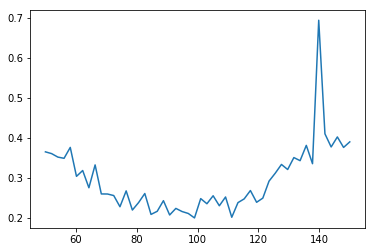

In [21]:
plt.plot(ds, tot_dists)
plt.show()

In [22]:
n_list, alpha_list, diff_list = get_coefs(lambdas, s, 100, film)

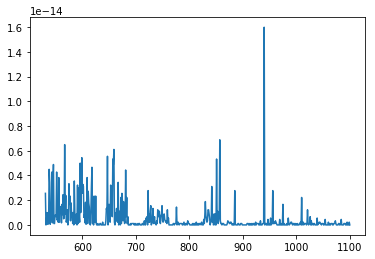

In [25]:
plt.plot(lambdas, diff_list)

In [27]:
def plot_transmittance(lambdas, n_list, alpha_list, s, d, film):
    predicted = [T_at_lambda(lambdas[i], n_list[i], s, d, alpha_list[i]) for i in range(len(lambdas))]
    plt.plot(lambdas, film, 'k-')
    plt.plot(lambdas, predicted, 'r-')
    plt.show()

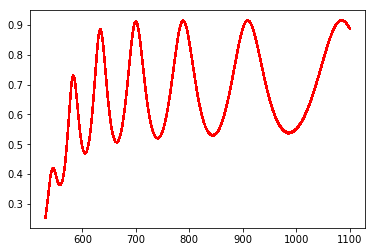

In [28]:
plot_transmittance(lambdas, n_list, alpha_list, s, 100, film)